## 1. Read the Raw Data
We start by reading in the raw dataset, displaying the first few rows of the dataframe, and taking a look at the columns and column types present.

In [44]:
import pandas as pd
import cufflinks as cf
import matplotlib
import matplotlib.pyplot as plt
import nltk

# Read the data
rows = []
with open('../released/ner/wnut16/train') as f:
    for line in f.readlines():
        if len(line) < 2:
            continue
        rows.append(line.rstrip('\n').split())
print('Number of rows read: {}'.format(len(rows)))

Number of rows read: 38902


In [45]:
data = pd.DataFrame(rows, columns=['term', 'entitytags'])
tokens=[]
for word in data['term']:
    tokens.append(word)
tokens2=nltk.pos_tag(tokens)
# print(data.tail())
# print(tokens2)
tokens3=[]
for x in tokens2:
        tokens3.append(x[1])
data['pos'] = tokens3

Named-entity tags The annotation scheme for named entities in the GMB distinguishes the following eight classes:

Person (PER) - Person entities are limited to individuals that are human or have human characteristics, such as divine entities.

Location (GEO) - Location entities are limited to geographical entities such as geographical areas and landmasses, bodies of water, and geological formations.

Organization (ORG) - Organization entities are limited to corporations, agencies, and other groups of people defined by an established organizational structure.

Geo-political Entity (GPE) - GPE entities are geographical regions defined by political and/or social groups. A GPE entity subsumes and does not distinguish between a city, a nation, its region, its government, or its people (LOC•ORG).

Artifact (ART) - Artifacts are limited to manmade objects, structures and abstract entities, including buildings, facilities, art and scientific theories.

Event (EVE) - Events are incidents and occasions that occur during a particular time.

Natural Object (NAT) - Natural objects are entities that occur naturally and are not manmade, such as diseases, biological entities and other living things.

Time (TIM) - Time entities are limited to references to certain temporal entities that have a name, such as the days of the week and months of a year. For all other temporal expressions the tagging layer timex is used (see below).

Other (O) - Other entities include all other words which do not fall in any of the categories above.

We would like to inspect whether there are any unexpected tags other than the ones mentioned above. If so, there might be some parsing issues we need to resolve.

In [46]:
# data['pos']
data['entitytags'].value_counts()

O                33274
B-geo-loc          758
B-person           718
I-other            616
B-other            543
B-company          497
I-person           382
I-product          334
I-facility         324
B-facility         256
B-product          217
I-geo-loc          159
B-musicartist      151
I-company          144
B-sportsteam       139
I-musicartist      113
I-movie             72
I-tvshow            54
I-sportsteam        52
B-movie             51
B-tvshow            48
Name: entitytags, dtype: int64

### Drop 'O' categorized words
In each sentence, there are many terms categorized as O than the other categories. O entity tag is not very informative because it only means "other". Keeping it makes us have hard time to inspect on the other entity tags. we would like to create a new data frame which drops the O categories so that we can investigate on the meaningful entity tags.

In [47]:
# Select the index that has entitytags as Other ('O')
otherTag = data[data['entitytags'] == 'O'].index
# Create a new dataframe and save the 'O' dropped version
tag_df = pd.DataFrame(data.drop(otherTag))

### Inspect entity tags
After dropping the O entity tags, we want to inspect entity and pos tags. Doing so helps us know the uniques, frequencies of each tag, and also see if there are any mis-categorized terms.

In [48]:
# Inspect the count of each entity tag
# including the uniques, top frequency words
entitytag = tag_df.groupby("entitytags")['term']
entitytags = entitytag.describe()
entitytags

,count,unique,top,freq
entitytags,,,,
B-company,497,256,Twitter,30
B-facility,256,165,The,18
B-geo-loc,758,442,San,30
B-movie,51,42,The,6
B-musicartist,151,125,Justin,9
B-other,543,402,FBI,9
B-person,718,509,Justin,19
B-product,217,176,Apple,10
B-sportsteam,139,123,Chelsea,3


In [55]:
pos_tag = tag_df.groupby('pos')['term']
pos_tags = pos_tag.describe()
pos_tags

,count,unique,top,freq
pos,,,,
(,5,1,(,5
),6,1,),6
",",6,1,",",6
.,24,3,.,22
:,15,2,:,11
CC,21,10,and,11
CD,103,62,2,10
DT,109,10,The,66
FW,8,7,de,2


### Add additional column
From the above inspections, all signs are clear. We decide to go ahead and add another column to the dataset.

In [49]:
# Add additional column that indicates 
# which sentence each word belongs to.
sentence_count = 0
sentence_count_list = []
# Loop through each term in data
for i in range(len(data['term'])):
    # Sentence ends with period
    # If it is period, then go to next sentence
    if data['term'].iloc[i] == '.':
        sentence_count_list.append(sentence_count)
        sentence_count = sentence_count+1
    # Else we are still in the current sentence
    else:
        sentence_count_list.append(sentence_count)

# Add sentence count column to dataframe
data['sentence_id'] = sentence_count_list
data.head(5)

,term,entitytags,pos,sentence_id
0,Made,O,VBN,0
1,it,O,PRP,0
2,back,O,RB,0
3,home,O,NN,0
4,to,O,TO,0


## 2. Data Visualization
In this section, we will visualize the data in four levels: the sentence level, the entity tags level, the pos tags level and the terms level. Visualizing in four perspective helps us have more tangible information on the data.

### Investigate number of tokens in each sentence
We would like to know at the sentence level, how many token per sentence on average? Doing so we can see whether the dataset is balanced. The sentences should usually be about 20 to 30 words long.

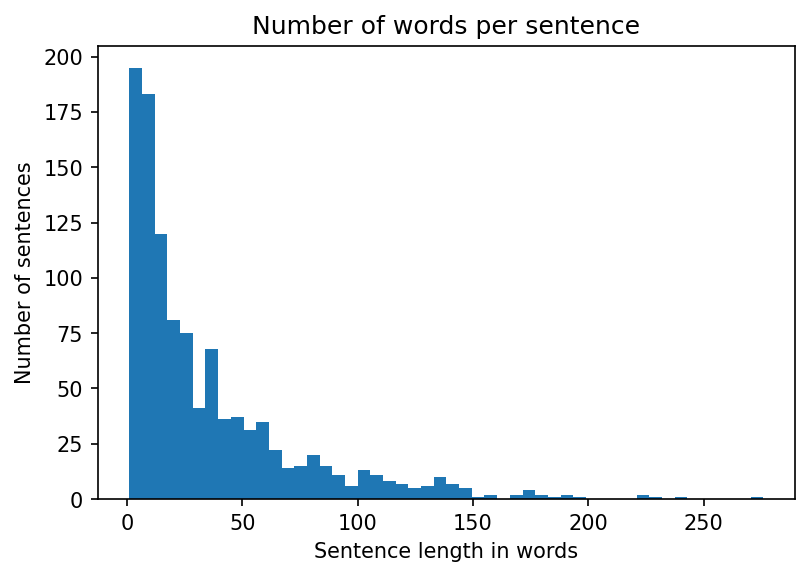

In [50]:
# Save sentence length to list
sentence_len = data['sentence_id'].value_counts().tolist()
# Plot sentence by length
plt.hist(sentence_len, bins=50)
plt.title('Number of words per sentence')
plt.xlabel('Sentence length in words')
plt.ylabel('Number of sentences')
plt.show()

On average most sentences contain 20 words. The tokens per sentence distribution is roughly symmetric, so the data is in good shape.

### Visualize Entity tag Distribution

In [51]:
# Visualize entity tags distribution
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
tag_df.groupby('entitytags').count()['term'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Entity Tags Distribution', xTitle='Entity tag name')

From the Entity Tags Distribution, we can see that B-GEO is the most frequently labeled entity tag. Which makes sense, because location entities are oftenly appear more frequently in the sentences.

Now, we would like to also visualize the count, unique, frequency data from the entity tags table. It tells us how many words are unique in each entity tag and how repetitive the document is.

<Figure size 7500x2250 with 0 Axes>

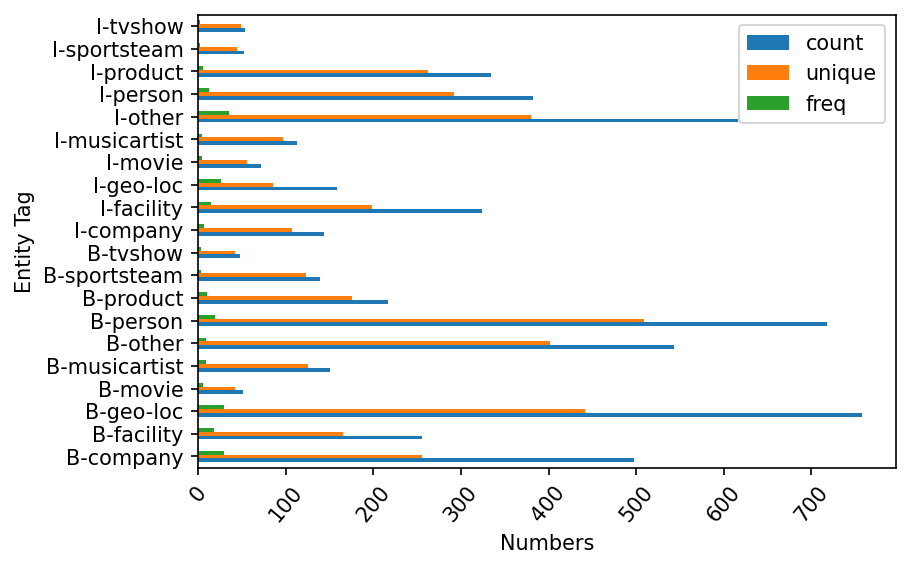

In [52]:
# Visualize entity tag frequency, uniques, counts
matplotlib.rcParams['figure.dpi'] = 150
plt.figure(figsize=(50,15))
entitytags.plot.barh()
plt.xticks(rotation=50)
plt.xlabel("Numbers")
plt.ylabel("Entity Tag")
plt.show()

Inspecting the counts of each entity tag and the uniques, top frequency words, we conclude that roughly I-PER, I-ORG, B-PER, B-ORG have more unique words in each entity tags. It means that the terms have more variety.

In [53]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
tag_df.groupby('pos').count()['term'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='POS Tags Distribution', xTitle='POS tag name')

<Figure size 17000x5100 with 0 Axes>

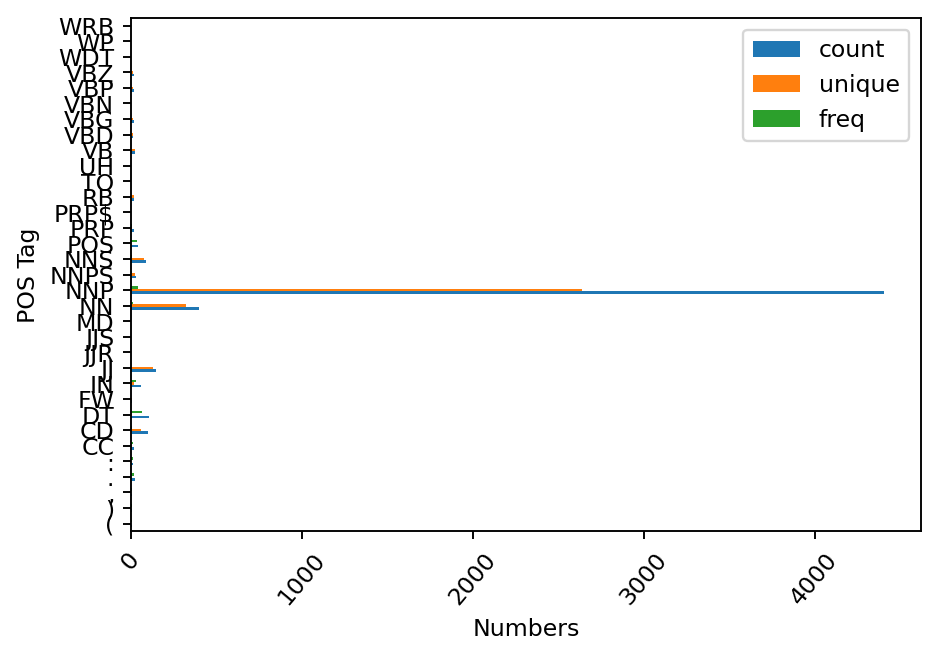

In [63]:
# Visualize entity tag frequency, uniques, counts
matplotlib.rcParams['figure.dpi'] = 170
plt.figure(figsize=(100,30))
pos_tags.plot.barh()
plt.xticks(rotation=50)
plt.xlabel("Numbers")
plt.ylabel("POS Tag")
plt.show()